# Método del Relé

Permite con un simple ensayo obtener el punto crítico.
Se intercala un relé en el lazo, de manera que 
- si $e>0$ => $u = hh$
- si $e<=0$ => $u = -hh$

In [6]:
import control as ctrl
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

Sistema a identificar


StateSpace(array([[-3.2, -3.6, -0.6],
       [ 1. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. ]]), array([[1.],
       [0.],
       [0.]]), array([[ 0.2, -0.6,  0.6]]), array([[0.]]))

Text(0, 0.5, '$u(t)$')

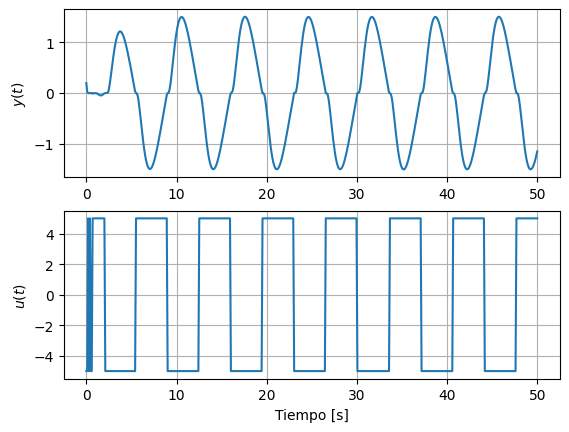

In [63]:
# Parámetros de la planta
tau = 5
K = 1
L = 2
# Apertura del relay
hh = 5

# Defino la planta (primer orden con retardo)
s = ctrl.TransferFunction.s
num_p, den_p = ctrl.pade(L, 2)
G = ctrl.series( K / (tau*s + 1) , ctrl.tf(num_p, den_p))
Gss = ctrl.tf2ss(G)
print('Sistema a identificar')
display(Gss)

# Vamos a excitarla en lazo cerrado interponiendo un relé
def modelo(t, x):
    x = np.reshape(x,(-1,1))    
    y = float(Gss.C @ x)
    e = -y
    if e>0:
        u = hh
    else:
        u = -hh
    xd = Gss.A @ x + Gss.B * u
    return xd.flatten()

t_span = (0, 50)
t_eval = np.linspace(t_span[0], t_span[1], 500)
sol = solve_ivp(modelo, t_span, [1,0,0], t_eval=t_eval, method='RK45')

# Recupero la salida de la planta desde los estados
t = sol.t
y = (Gss.C @ sol.y).flatten() + float(Gss.D)*0.0

# Recupero la señal de entrada a la planta (la salida del relé)
u = np.array([hh*np.sign(-yt) for yt in y])

#t,y = ctrl.step_response(Gss)

plt.subplot(211)
plt.plot(t,y)
plt.grid()
plt.ylabel('$y(t)$')
plt.subplot(212)
plt.plot(t,u)
plt.grid()
plt.xlabel('Tiempo [s]')
plt.ylabel('$u(t)$')


In [67]:
# Realizo mediciones sobre las señales
from scipy.signal import find_peaks

idx = (3*len(y))//4
print(f"Analizando salida luego de transitorios t={t[idx]:.1f}")
y_perm = y[idx:-1]
u_perm = u[idx:-1]
peaks, _ = find_peaks(y_perm)  
# promedio de distancia entre picos
Tu = np.mean(np.diff(t[peaks]))  
print(f"Periodo de oscilación Tu ={Tu:.2f}")
print(f"Periodo de oscilación w_u ={2*np.pi/Tu:.2f}")

a = (np.max(y_perm) - np.min(y_perm)) / 2
print(f"Amplitud de oscilación A = {a:.2f}")

Ku = 4*hh / (np.pi * a)
print(f"Ganancia crítica Ku = {Ku:.2f}")

Analizando salida luego de transitorios t=37.6
Periodo de oscilación Tu =7.11
Periodo de oscilación w_u =0.88
Amplitud de oscilación A = 1.50
Ganancia crítica Ku = 4.24


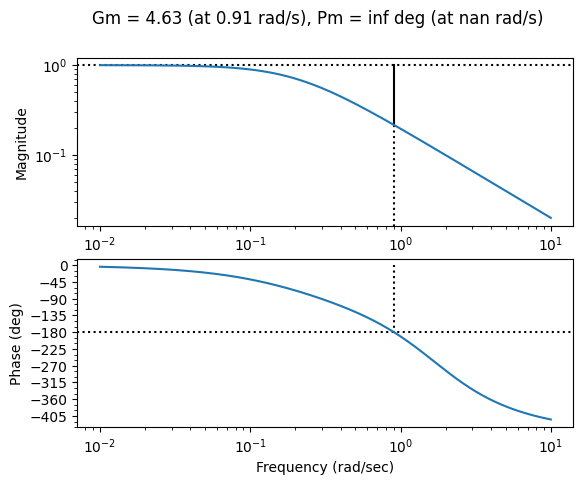

In [72]:
# Corroboramos el resultado de la identificación en la planta teórica
mag, phase, omega = ctrl.bode_plot(G,plot=True,margins=True)